<a href="https://colab.research.google.com/github/AndroGari/Financial-Sentiment-Analysis/blob/master/Financial_Sentiment_Analysis_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install text_hammer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.2
    Uninstalling beautifulsoup4-4.11.2:
      Successfully uninstalled beautifulsoup4-4.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.22 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.1 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import text_hammer as th

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/data.csv')

In [ ]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


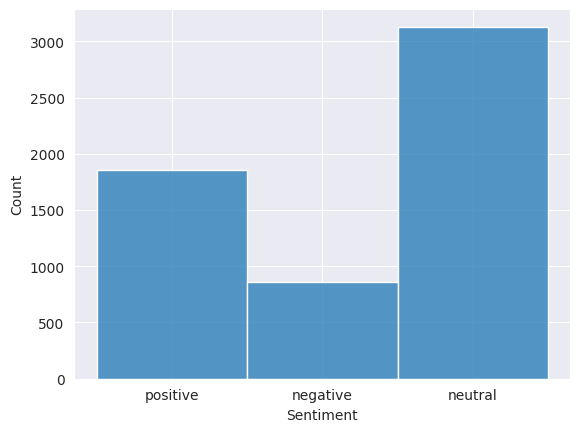

In [ ]:
import seaborn as sns

sns.set_style('darkgrid')
sns.histplot(x='Sentiment',data=df)
plt.show()

In [ ]:
df['len'] = list(map(lambda x: len(str(x).split(' ')),df['Sentence']))
df.head()

,Sentence,Sentiment,len
0,The GeoSolutions technology will leverage Bene...,positive,32
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,11
2,"For the last quarter of 2010 , Componenta 's n...",positive,39
3,According to the Finnish-Russian Chamber of Co...,neutral,20
4,The Swedish buyout firm has sold its remaining...,neutral,23


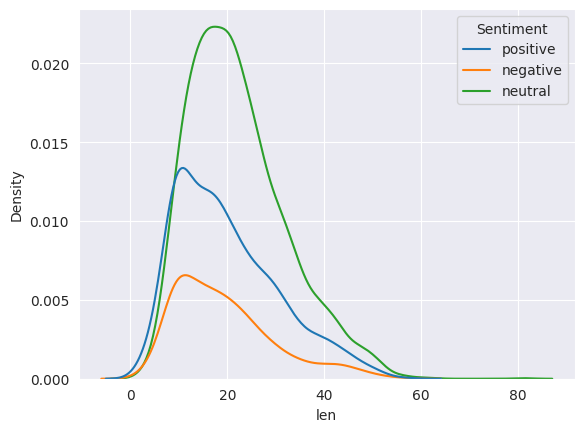

In [ ]:
sns.kdeplot(x='len',hue='Sentiment',data=df)
plt.show()

In [ ]:
mapdf = {'positive':0,'negative':1,'neutral':2}
df['Sentiment'] = list(map(lambda x:mapdf[x],df['Sentiment']))
df.head()

,Sentence,Sentiment,len
0,The GeoSolutions technology will leverage Bene...,0,32
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",1,11
2,"For the last quarter of 2010 , Componenta 's n...",0,39
3,According to the Finnish-Russian Chamber of Co...,2,20
4,The Swedish buyout firm has sold its remaining...,2,23


In [ ]:
print(df['Sentiment'].corr(df['len']))

0.10137114484667775


In [ ]:
sentences = df['Sentence'].copy()[:]
sentences = sentences.to_list()
sentences = list(map(lambda x: x.lower(),sentences))
sentences = list(map(lambda x: th.cont_exp(x),sentences))
sentences = list(map(lambda x: th.remove_emails(x),sentences))
sentences = list(map(lambda x: th.remove_emails(x),sentences))
sentences = list(map(lambda x: th.remove_html_tags(x),sentences))
sentences = list(map(lambda x: th.remove_stopwords(x),sentences))
sentences = list(map(lambda x: th.remove_special_chars(x),sentences))
sentences = list(map(lambda x: th.remove_accented_chars(x),sentences))
sentences = list(map(lambda x: th.make_base(x),sentences))

In [ ]:
!pip install nltk

In [ ]:
import nltk

nltk.download('punkt')
from tqdm import tqdm_notebook as tqdm

pairs = []
for sent in tqdm(sentences):
    pairs.extend(nltk.word_tokenize(sent))
freq = nltk.FreqDist(pairs)
freq.most_common(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


  0%|          | 0/5842 [00:00<?, ?it/s]

[('eur', 1284),
 ('company', 916),
 ('mn', 729),
 ('sale', 607),
 ('profit', 584),
 ('say', 574),
 ('finnish', 527),
 ('share', 514),
 ('net', 499),
 ('million', 493)]

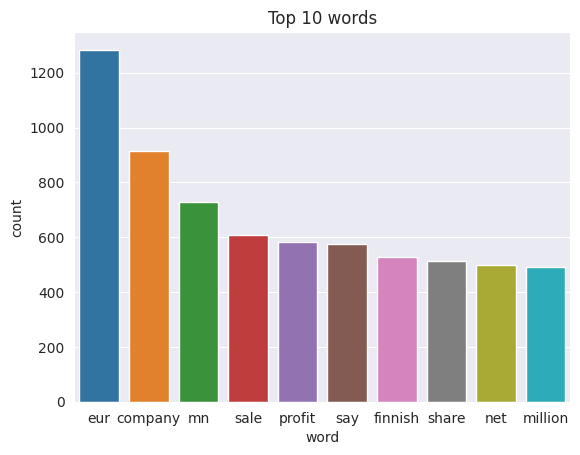

In [ ]:
tempdf = pd.DataFrame(freq.most_common(10),  columns=['word', 'count'])
sns.barplot(x='word',y='count',data=tempdf)
plt.title("Top 10 words")
plt.show()

In [ ]:
!pip install keras

In [ ]:
from sklearn.model_selection import train_test_split
# from keras.utils.all_utils import to_categorical
from tensorflow.python.keras.utils.np_utils import to_categorical #update of keras and tensorflow

x = sentences.copy()
y = to_categorical(df['Sentiment'])
X_train,X_test, y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=42)

In [ ]:
from keras.preprocessing.text import Tokenizer


num_words = 12000
tokenizer=Tokenizer(num_words,lower=True)

df_total = pd.concat([pd.Series(X_train), pd.Series(X_test)], axis = 0)
tokenizer.fit_on_texts(df_total)

In [ ]:
# from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_ =tokenizer.texts_to_sequences(X_train)
X_train_pad=pad_sequences(X_train_,maxlen=81,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = 81, padding = 'post')

In [ ]:
print(X_train_pad.shape,X_test_pad.shape)

(4089, 81) (1753, 81)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Bidirectional,Embedding,Dropout

In [ ]:
lstm = Sequential()
lstm.add(Embedding(input_dim = num_words, output_dim = 100, input_length= X_train_pad.shape[1]))

lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(128,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(256,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(128,return_sequences=False)))
lstm.add(Dense(64,activation='tanh'))
lstm.add(Dense(32,activation='tanh'))
lstm.add(Dense(10,activation='tanh'))
lstm.add(Dense(3,activation='softmax'))

In [ ]:
lstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 81, 100)           1200000   
                                                                 
 dropout (Dropout)           (None, 81, 100)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 81, 256)          234496    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 81, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 81, 512)          1050624   
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 81, 512)           0

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [ ]:
lstm_history = lstm.fit(X_train_pad,y_train, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test),verbose = 1, callbacks= [es, mc])

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.9353 - accuracy: 0.5608
Epoch 1: val_accuracy improved from -inf to 0.64746, saving model to ./model.h5
64/64 [==============================] - 139s 2s/step - loss: 0.9353 - accuracy: 0.5608 - val_loss: 0.8457 - val_accuracy: 0.6475
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.7398
Epoch 2: val_accuracy improved from 0.64746 to 0.68625, saving model to ./model.h5
64/64 [==============================] - 135s 2s/step - loss: 0.6537 - accuracy: 0.7398 - val_loss: 0.7743 - val_accuracy: 0.6863
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.4378 - accuracy: 0.8188
Epoch 3: val_accuracy did not improve from 0.68625
64/64 [==============================] - 134s 2s/step - loss: 0.4378 - accuracy: 0.8188 - val_loss: 0.9190 - val_accuracy: 0.6788
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8745
Epoch 4: val_accurac

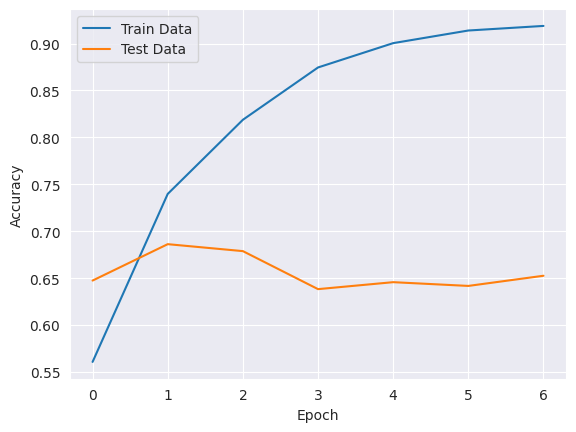

In [ ]:
plt.plot(lstm_history.history['accuracy'], label='Train Data')
plt.plot(lstm_history.history['val_accuracy'], label='Test Data')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.8, 1])

plt.legend(loc='best')
plt.show()

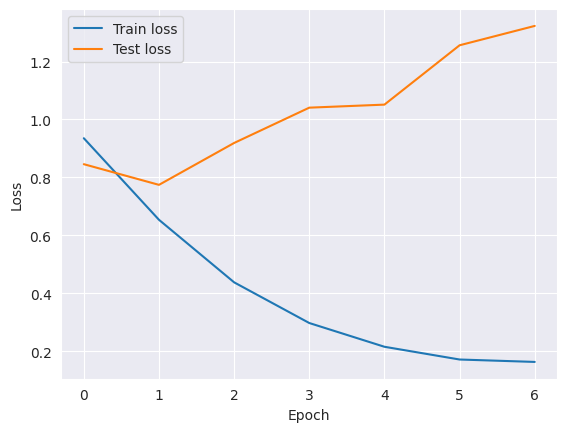

In [ ]:
plt.plot(lstm_history.history['loss'], label='Train loss')
plt.plot(lstm_history.history['val_loss'], label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

predictions = lstm.predict(X_test_pad)
target_names=['positive','negative','neutral']
print(classification_report(np.argmax(y_test,axis=1),np.argmax(predictions,axis=1),target_names=target_names))

55/55 [==============================] - 18s 280ms/step
              precision    recall  f1-score   support

    positive       0.62      0.77      0.69       556
    negative       0.35      0.16      0.22       258
     neutral       0.71      0.72      0.71       939

    accuracy                           0.65      1753
   macro avg       0.56      0.55      0.54      1753
weighted avg       0.63      0.65      0.63      1753



In [ ]:
import os
import cv2